### Install project

In [9]:
!git clone https://github.com/kornelro/cv_project.git

fatal: destination path 'cv_project' already exists and is not an empty directory.


In [10]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=303f19c26d76c3b55fe054c3e12c74b24b891b9ea553d1c9637528ea13b6625d
  Stored in directory: /tmp/pip-ephem-wheel-cache-un3lyq60/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0


### Mount drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [13]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-depn0b1w
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-depn0b1w
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=2782b6dbc4febcaf062c307009a33e00dead2140b8f78062540ae04f67c27975
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxrz1708/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [14]:
pip install stellargraph

In [22]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classification_models.keras import Classifiers
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet18
# Pipeline: Norm

### Load dataset

In [16]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet.pickle'

In [17]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet18

In [18]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 50

In [19]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(
    input_shape=X[0].shape,
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers:
    layer.trainable = False

x = K.layers.GlobalAveragePooling2D()(base_model.output)
output = K.layers.Dense(2, activation='softmax')(x)
model = K.models.Model(inputs=[base_model.input], outputs=[output])


model.compile(
    optimizer=K.optimizers.Adam(0.01),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

44924928/44920640 [==============================] - 1s 0us/step
Epoch 1/50
85/85 [==============================] - 10s 24ms/step - loss: 0.7024 - accuracy: 0.5120 - val_loss: 0.6506 - val_accuracy: 0.4904
Epoch 2/50
85/85 [==============================] - 1s 14ms/step - loss: 0.6455 - accuracy: 0.6426 - val_loss: 0.5992 - val_accuracy: 0.7739
Epoch 3/50
85/85 [==============================] - 1s 13ms/step - loss: 0.5963 - accuracy: 0.7625 - val_loss: 0.5682 - val_accuracy: 0.7335
Epoch 4/50
85/85 [==============================] - 1s 13ms/step - loss: 0.5600 - accuracy: 0.8017 - val_loss: 0.5380 - val_accuracy: 0.7696
Epoch 5/50
85/85 [==============================] - 1s 13ms/step - loss: 0.5361 - accuracy: 0.7895 - val_loss: 0.5073 - val_accuracy: 0.8631
Epoch 6/50
85/85 [==============================] - 1s 13ms/step - loss: 0.5082 - accuracy: 0.8184 - val_loss: 0.4952 - val_accuracy: 0.8747
Epoch 7/50
85/85 [==============================] - 1s 13ms/step - loss: 0.4895 - accura

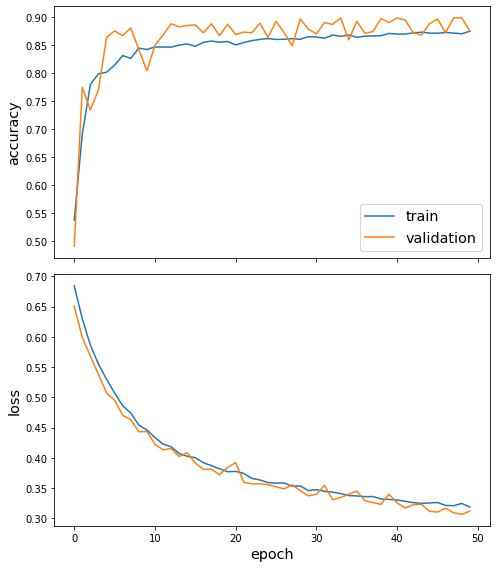

In [20]:
plot_history(history)

### Validation

In [ ]:
data = None

In [27]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

#### treshold = 0.7; nms_overlap=0.4

In [29]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.7,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/vehicules/t7nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt


  2%|▏         | 1/66 [00:01<01:30,  1.40s/it]

9


  3%|▎         | 2/66 [00:02<01:24,  1.31s/it]

3


  5%|▍         | 3/66 [00:03<01:18,  1.25s/it]

16


  6%|▌         | 4/66 [00:04<01:15,  1.21s/it]

25


  8%|▊         | 5/66 [00:05<01:12,  1.18s/it]

20


  9%|▉         | 6/66 [00:06<01:09,  1.16s/it]

42


 11%|█         | 7/66 [00:08<01:07,  1.15s/it]

8


 12%|█▏        | 8/66 [00:09<01:06,  1.14s/it]

33


 14%|█▎        | 9/66 [00:10<01:04,  1.13s/it]

11


 15%|█▌        | 10/66 [00:11<01:03,  1.13s/it]

3


 17%|█▋        | 11/66 [00:12<01:02,  1.13s/it]

11


 18%|█▊        | 12/66 [00:13<01:00,  1.13s/it]

16


 20%|█▉        | 13/66 [00:14<01:00,  1.13s/it]

0


 21%|██        | 14/66 [00:15<00:58,  1.13s/it]

149


 23%|██▎       | 15/66 [00:17<00:57,  1.13s/it]

153


 24%|██▍       | 16/66 [00:18<00:56,  1.12s/it]

6


 26%|██▌       | 17/66 [00:19<00:54,  1.12s/it]

51


 27%|██▋       | 18/66 [00:20<00:53,  1.12s/it]

96


 29%|██▉       | 19/66 [00:21<00:52,  1.12s/it]

16


 30%|███       | 20/66 [00:22<00:51,  1.12s/it]

57


 32%|███▏      | 21/66 [00:23<00:50,  1.12s/it]

60


 33%|███▎      | 22/66 [00:24<00:49,  1.12s/it]

6


 35%|███▍      | 23/66 [00:26<00:48,  1.12s/it]

2


 36%|███▋      | 24/66 [00:27<00:46,  1.11s/it]

44


 38%|███▊      | 25/66 [00:28<00:45,  1.11s/it]

3


 39%|███▉      | 26/66 [00:29<00:44,  1.12s/it]

18


 41%|████      | 27/66 [00:30<00:45,  1.17s/it]

24


 42%|████▏     | 28/66 [00:31<00:43,  1.15s/it]

32


 44%|████▍     | 29/66 [00:32<00:42,  1.14s/it]

34


 45%|████▌     | 30/66 [00:34<00:40,  1.14s/it]

21


 47%|████▋     | 31/66 [00:35<00:39,  1.13s/it]

57


 48%|████▊     | 32/66 [00:36<00:38,  1.13s/it]

10


 50%|█████     | 33/66 [00:37<00:37,  1.13s/it]

2


 52%|█████▏    | 34/66 [00:38<00:36,  1.13s/it]

17


 53%|█████▎    | 35/66 [00:39<00:34,  1.12s/it]

10


 55%|█████▍    | 36/66 [00:40<00:33,  1.13s/it]

0


 56%|█████▌    | 37/66 [00:41<00:32,  1.12s/it]

10


 58%|█████▊    | 38/66 [00:42<00:31,  1.12s/it]

4


 59%|█████▉    | 39/66 [00:44<00:30,  1.12s/it]

10


 61%|██████    | 40/66 [00:45<00:29,  1.12s/it]

4


 62%|██████▏   | 41/66 [00:46<00:27,  1.12s/it]

15


 64%|██████▎   | 42/66 [00:47<00:26,  1.12s/it]

42


 65%|██████▌   | 43/66 [00:48<00:25,  1.12s/it]

26


 67%|██████▋   | 44/66 [00:49<00:24,  1.12s/it]

46


 68%|██████▊   | 45/66 [00:50<00:23,  1.12s/it]

5


 70%|██████▉   | 46/66 [00:51<00:22,  1.13s/it]

46


 71%|███████   | 47/66 [00:53<00:21,  1.12s/it]

9


 73%|███████▎  | 48/66 [00:54<00:20,  1.12s/it]

30


 74%|███████▍  | 49/66 [00:55<00:19,  1.12s/it]

7


 76%|███████▌  | 50/66 [00:56<00:18,  1.13s/it]

14


 77%|███████▋  | 51/66 [00:57<00:16,  1.13s/it]

58


 79%|███████▉  | 52/66 [00:58<00:15,  1.14s/it]

10


 80%|████████  | 53/66 [00:59<00:14,  1.14s/it]

85


 82%|████████▏ | 54/66 [01:01<00:13,  1.13s/it]

19


 83%|████████▎ | 55/66 [01:02<00:12,  1.13s/it]

18


 85%|████████▍ | 56/66 [01:03<00:11,  1.14s/it]

37


 86%|████████▋ | 57/66 [01:04<00:10,  1.13s/it]

0


 88%|████████▊ | 58/66 [01:05<00:09,  1.14s/it]

32


 89%|████████▉ | 59/66 [01:06<00:07,  1.13s/it]

6


 91%|█████████ | 60/66 [01:07<00:06,  1.12s/it]

42


 92%|█████████▏| 61/66 [01:08<00:05,  1.11s/it]

7


 94%|█████████▍| 62/66 [01:09<00:04,  1.11s/it]

25


 95%|█████████▌| 63/66 [01:11<00:03,  1.11s/it]

6


 97%|█████████▋| 64/66 [01:12<00:02,  1.11s/it]

21


 98%|█████████▊| 65/66 [01:13<00:01,  1.11s/it]

96


100%|██████████| 66/66 [01:14<00:00,  1.13s/it]

80



Precision: 0.037
Recall: 0.459
F1Score: 0.069


#### treshold = 0.8; nms_overlap=0.4

In [30]:
del processed_images

In [31]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/vehicules/t8nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt


  2%|▏         | 1/66 [00:01<01:21,  1.25s/it]

5


  3%|▎         | 2/66 [00:02<01:17,  1.21s/it]

1


  5%|▍         | 3/66 [00:03<01:14,  1.18s/it]

8


  6%|▌         | 4/66 [00:04<01:11,  1.16s/it]

12


  8%|▊         | 5/66 [00:05<01:09,  1.14s/it]

9


  9%|▉         | 6/66 [00:06<01:08,  1.14s/it]

22


 11%|█         | 7/66 [00:07<01:06,  1.13s/it]

7


 12%|█▏        | 8/66 [00:09<01:05,  1.13s/it]

20


 14%|█▎        | 9/66 [00:10<01:03,  1.12s/it]

8


 15%|█▌        | 10/66 [00:11<01:02,  1.11s/it]

1


 17%|█▋        | 11/66 [00:12<01:00,  1.11s/it]

5


 18%|█▊        | 12/66 [00:13<00:59,  1.10s/it]

9


 20%|█▉        | 13/66 [00:14<00:58,  1.10s/it]

0


 21%|██        | 14/66 [00:15<00:57,  1.10s/it]

86


 23%|██▎       | 15/66 [00:16<00:59,  1.17s/it]

85


 24%|██▍       | 16/66 [00:18<00:57,  1.15s/it]

2


 26%|██▌       | 17/66 [00:19<00:55,  1.14s/it]

28


 27%|██▋       | 18/66 [00:20<00:54,  1.13s/it]

59


 29%|██▉       | 19/66 [00:21<00:52,  1.12s/it]

5


 30%|███       | 20/66 [00:22<00:51,  1.12s/it]

38


 32%|███▏      | 21/66 [00:23<00:50,  1.11s/it]

26


 33%|███▎      | 22/66 [00:24<00:48,  1.11s/it]

1


 35%|███▍      | 23/66 [00:25<00:47,  1.11s/it]

2


 36%|███▋      | 24/66 [00:26<00:46,  1.11s/it]

26


 38%|███▊      | 25/66 [00:27<00:45,  1.10s/it]

2


 39%|███▉      | 26/66 [00:29<00:44,  1.10s/it]

6


 41%|████      | 27/66 [00:30<00:42,  1.10s/it]

15


 42%|████▏     | 28/66 [00:31<00:41,  1.10s/it]

21


 44%|████▍     | 29/66 [00:32<00:40,  1.10s/it]

29


 45%|████▌     | 30/66 [00:33<00:39,  1.11s/it]

14


 47%|████▋     | 31/66 [00:34<00:38,  1.11s/it]

20


 48%|████▊     | 32/66 [00:35<00:37,  1.11s/it]

5


 50%|█████     | 33/66 [00:36<00:36,  1.10s/it]

1


 52%|█████▏    | 34/66 [00:37<00:35,  1.10s/it]

11


 53%|█████▎    | 35/66 [00:39<00:34,  1.10s/it]

5


 55%|█████▍    | 36/66 [00:40<00:32,  1.10s/it]

0


 56%|█████▌    | 37/66 [00:41<00:31,  1.10s/it]

4


 58%|█████▊    | 38/66 [00:42<00:30,  1.10s/it]

2


 59%|█████▉    | 39/66 [00:43<00:29,  1.10s/it]

6


 61%|██████    | 40/66 [00:44<00:28,  1.10s/it]

2


 62%|██████▏   | 41/66 [00:45<00:27,  1.10s/it]

9


 64%|██████▎   | 42/66 [00:46<00:26,  1.10s/it]

23


 65%|██████▌   | 43/66 [00:47<00:25,  1.10s/it]

11


 67%|██████▋   | 44/66 [00:48<00:24,  1.11s/it]

25


 68%|██████▊   | 45/66 [00:50<00:23,  1.11s/it]

1


 70%|██████▉   | 46/66 [00:51<00:22,  1.11s/it]

23


 71%|███████   | 47/66 [00:52<00:21,  1.11s/it]

5


 73%|███████▎  | 48/66 [00:53<00:20,  1.11s/it]

17


 74%|███████▍  | 49/66 [00:54<00:18,  1.11s/it]

5


 76%|███████▌  | 50/66 [00:55<00:17,  1.11s/it]

8


 77%|███████▋  | 51/66 [00:56<00:16,  1.11s/it]

30


 79%|███████▉  | 52/66 [00:57<00:15,  1.11s/it]

6


 80%|████████  | 53/66 [00:58<00:14,  1.11s/it]

52


 82%|████████▏ | 54/66 [01:00<00:13,  1.10s/it]

8


 83%|████████▎ | 55/66 [01:01<00:12,  1.10s/it]

8


 85%|████████▍ | 56/66 [01:02<00:11,  1.10s/it]

25


 86%|████████▋ | 57/66 [01:03<00:09,  1.11s/it]

0


 88%|████████▊ | 58/66 [01:04<00:08,  1.11s/it]

16


 89%|████████▉ | 59/66 [01:05<00:07,  1.11s/it]

4


 91%|█████████ | 60/66 [01:06<00:06,  1.12s/it]

33


 92%|█████████▏| 61/66 [01:07<00:05,  1.11s/it]

2


 94%|█████████▍| 62/66 [01:08<00:04,  1.11s/it]

10


 95%|█████████▌| 63/66 [01:10<00:03,  1.11s/it]

0


 97%|█████████▋| 64/66 [01:11<00:02,  1.11s/it]

4


 98%|█████████▊| 65/66 [01:12<00:01,  1.11s/it]

46


100%|██████████| 66/66 [01:13<00:00,  1.11s/it]

56



Precision: 0.049
Recall: 0.353
F1Score: 0.087


#### treshold = 0.9; nms_overlap=0.4

In [32]:
del processed_images

In [33]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet18/vehicules/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt


  2%|▏         | 1/66 [00:01<01:18,  1.21s/it]

0


  3%|▎         | 2/66 [00:02<01:15,  1.18s/it]

0


  5%|▍         | 3/66 [00:03<01:16,  1.22s/it]

2


  6%|▌         | 4/66 [00:04<01:13,  1.19s/it]

4


  8%|▊         | 5/66 [00:05<01:10,  1.16s/it]

2


  9%|▉         | 6/66 [00:06<01:08,  1.14s/it]

10


 11%|█         | 7/66 [00:08<01:06,  1.13s/it]

3


 12%|█▏        | 8/66 [00:09<01:05,  1.12s/it]

12


 14%|█▎        | 9/66 [00:10<01:03,  1.12s/it]

7


 15%|█▌        | 10/66 [00:11<01:02,  1.12s/it]

0


 17%|█▋        | 11/66 [00:12<01:01,  1.12s/it]

3


 18%|█▊        | 12/66 [00:13<01:00,  1.11s/it]

4


 20%|█▉        | 13/66 [00:14<00:58,  1.11s/it]

0


 21%|██        | 14/66 [00:15<00:57,  1.11s/it]

31


 23%|██▎       | 15/66 [00:16<00:56,  1.10s/it]

17


 24%|██▍       | 16/66 [00:18<00:55,  1.11s/it]

2


 26%|██▌       | 17/66 [00:19<00:54,  1.10s/it]

8


 27%|██▋       | 18/66 [00:20<00:52,  1.10s/it]

32


 29%|██▉       | 19/66 [00:21<00:51,  1.10s/it]

0


 30%|███       | 20/66 [00:22<00:50,  1.10s/it]

18


 32%|███▏      | 21/66 [00:23<00:49,  1.10s/it]

5


 33%|███▎      | 22/66 [00:24<00:48,  1.10s/it]

0


 35%|███▍      | 23/66 [00:25<00:47,  1.10s/it]

0


 36%|███▋      | 24/66 [00:26<00:46,  1.10s/it]

7


 38%|███▊      | 25/66 [00:27<00:45,  1.11s/it]

0


 39%|███▉      | 26/66 [00:29<00:44,  1.11s/it]

3


 41%|████      | 27/66 [00:30<00:43,  1.11s/it]

4


 42%|████▏     | 28/66 [00:31<00:42,  1.11s/it]

13


 44%|████▍     | 29/66 [00:32<00:40,  1.11s/it]

10


 45%|████▌     | 30/66 [00:33<00:39,  1.11s/it]

7


 47%|████▋     | 31/66 [00:34<00:38,  1.11s/it]

6


 48%|████▊     | 32/66 [00:35<00:37,  1.11s/it]

0


 50%|█████     | 33/66 [00:36<00:36,  1.10s/it]

1


 52%|█████▏    | 34/66 [00:37<00:35,  1.11s/it]

3


 53%|█████▎    | 35/66 [00:39<00:34,  1.11s/it]

1


 55%|█████▍    | 36/66 [00:40<00:33,  1.11s/it]

0


 56%|█████▌    | 37/66 [00:41<00:32,  1.10s/it]

3


 58%|█████▊    | 38/66 [00:42<00:31,  1.11s/it]

0


 59%|█████▉    | 39/66 [00:43<00:29,  1.10s/it]

3


 61%|██████    | 40/66 [00:44<00:28,  1.10s/it]

0


 62%|██████▏   | 41/66 [00:45<00:27,  1.10s/it]

3


 64%|██████▎   | 42/66 [00:46<00:26,  1.10s/it]

14


 65%|██████▌   | 43/66 [00:47<00:25,  1.10s/it]

5


 67%|██████▋   | 44/66 [00:48<00:24,  1.10s/it]

7


 68%|██████▊   | 45/66 [00:50<00:23,  1.12s/it]

0


 70%|██████▉   | 46/66 [00:51<00:22,  1.12s/it]

17


 71%|███████   | 47/66 [00:52<00:21,  1.12s/it]

2


 73%|███████▎  | 48/66 [00:53<00:20,  1.13s/it]

8


 74%|███████▍  | 49/66 [00:54<00:19,  1.13s/it]

3


 76%|███████▌  | 50/66 [00:55<00:17,  1.12s/it]

5


 77%|███████▋  | 51/66 [00:56<00:16,  1.12s/it]

7


 79%|███████▉  | 52/66 [00:57<00:15,  1.13s/it]

0


 80%|████████  | 53/66 [00:59<00:14,  1.13s/it]

26


 82%|████████▏ | 54/66 [01:00<00:13,  1.12s/it]

2


 83%|████████▎ | 55/66 [01:01<00:12,  1.12s/it]

7


 85%|████████▍ | 56/66 [01:02<00:11,  1.11s/it]

17


 86%|████████▋ | 57/66 [01:03<00:10,  1.12s/it]

0


 88%|████████▊ | 58/66 [01:04<00:09,  1.18s/it]

8


 89%|████████▉ | 59/66 [01:05<00:08,  1.16s/it]

0


 91%|█████████ | 60/66 [01:07<00:06,  1.14s/it]

18


 92%|█████████▏| 61/66 [01:08<00:05,  1.13s/it]

2


 94%|█████████▍| 62/66 [01:09<00:04,  1.13s/it]

1


 95%|█████████▌| 63/66 [01:10<00:03,  1.12s/it]

0


 97%|█████████▋| 64/66 [01:11<00:02,  1.12s/it]

1


 98%|█████████▊| 65/66 [01:12<00:01,  1.13s/it]

15


100%|██████████| 66/66 [01:13<00:00,  1.12s/it]

24



Precision: 0.071
Recall: 0.224
F1Score: 0.108
